In [1]:
import pandas as pd
import numpy as np
import sklearn as sk

#My own module for SVM analysis
import main_funcs

In [2]:
lines = ["Bima1", "Kolf2", "Kolf3", "Kucg2", "Letw5", "Podx1", "Qolg1", "Sojd3", "Wibj2", "Yoch6"]


In [5]:
DE_genes=pd.read_csv("DEGs_TPMs.csv", index_col=0)

In [15]:
#Script for predictive accuracy of the SVM pipeline without bootstrapping.
#For Supplementary Fig. 4D, run with different annotation files

epig_vars=['K4', 'K9', 'K27', 'ATAC']
accuracy=[]
tgts=[]
prob_preds=[]

#Seed initialisation for Kmeans
np.random.seed(34601)

#Load from file and preparing the data for the SVM
intensities_K4 = pd.read_csv('DEGs_scores/DE_genes_K4me3_geneSVM10.csv')
intensities_K4_tx = pd.read_csv('DEGs_scores/DE_genes_K4me3_tx_pm1kSVM10.csv')
intensities_K4_promoters = pd.read_csv('DEGs_scores/DE_genes_K4me3_prompm1kSVM10.csv')

intensities_K4_pm1k = np.maximum(intensities_K4_tx, intensities_K4_promoters)
intensities_K4 = np.maximum(intensities_K4, intensities_K4_pm1k)
intensities_K4 = pd.DataFrame(intensities_K4, columns=intensities_K4.columns, index=intensities_K4.index)
    
intensities_K9 = pd.read_csv('DEGs_scores/DE_genes_K9me3_geneSVM10.csv')
#intensities_K9 = pd.read_csv('DEGs_scores/DE_genes_K9me3_prompm1kSVM10.csv') # Use for promoter annotation
#intensities_K9 = pd.read_csv('DEGs_scores/DE_genes_K9me3_genem1kSVM10.csv') # Use for gene body annotation
    
intensities_K27 = pd.read_csv('DEGs_scores/DE_genes_K27me3_geneSVM10.csv')
#intensities_K27 = pd.read_csv('DEGs_scores/DE_genes_K27me3_prompm1kSVM10.csv') # Use for promoter annotation
#intensities_K27 = pd.read_csv('DEGs_scores/DE_genes_K27me3_genem1kSVM10.csv') # Use for gene body annotation
    
intensities_ATAC = pd.read_csv('DEGs_scores/DE_genes_ATAC_geneSVM10.csv')
intensities_ATAC_tx = pd.read_csv('DEGs_scores/DE_genes_ATAC_tx_pm1kSVM10.csv')
intensities_ATAC_promoters = pd.read_csv('DEGs_scores/DE_genes_ATAC_prompm1kSVM10.csv')

intensities_ATAC_pm1k = np.maximum(intensities_ATAC_tx, intensities_ATAC_promoters)
intensities_ATAC = np.maximum(intensities_ATAC, intensities_ATAC_pm1k)
intensities_ATAC = pd.DataFrame(intensities_ATAC, columns=intensities_ATAC.columns, index=intensities_ATAC.index)

#Cycle over all cell lines to test all of them from the other 9
for test_line in lines:
    #Binarise transcription for the training data and assign a binarisation to the test data (ground truth).
    training_lines=lines.copy()
    training_lines.remove(test_line)
    DE_bin_train, test_ground_truth=main_funcs.binarize_test(DE_genes,training_lines, test_line)

    #Load the training data for each gene
    vars = pd.DataFrame(columns=['geneid', 'line', 'K4', 'K9', 'K27', 'ATAC', 'expression'])
    for line in training_lines:
        for gene in DE_bin_train['geneid']:
            vars.loc[len(vars)] = [gene, line, intensities_K4.loc[intensities_K4['geneid'] == gene, line].values[0], 
                                   intensities_K9.loc[intensities_K9['geneid'] == gene, line].values[0], 
                                   intensities_K27.loc[intensities_K27['geneid'] == gene, line].values[0], 
                                   intensities_ATAC.loc[intensities_ATAC['geneid'] == gene, line].values[0], 
                                   DE_bin_train.loc[DE_bin_train['geneid'] == gene, line + '_binary'].values[0]]

    #Create the test dataset             
    genes_test=pd.DataFrame(columns=['geneid', 'test_line', 'K4', 'K9', 'K27', 'ATAC'])
    for gene in DE_bin_train['geneid']:
        genes_test.loc[len(genes_test)] = [gene, test_line,
                                intensities_K4.loc[intensities_K4['geneid'] == gene, test_line].values[0], 
                                intensities_K9.loc[intensities_K9['geneid'] == gene, test_line].values[0], 
                                intensities_K27.loc[intensities_K27['geneid'] == gene, test_line].values[0], 
                                intensities_ATAC.loc[intensities_ATAC['geneid'] == gene, test_line].values[0]]
    #SVM for prediction
    probs_prediction, prediction=main_funcs.SVM_prediction(DE_bin_train['geneid'], vars, genes_test, epig_vars)
    #ROC curve and save to file
    tgt=test_ground_truth.transcription.to_numpy(dtype=bool)
    fpr, tpr, thres=sk.metrics.roc_curve(tgt,probs_prediction)
    filename="AUCs/"+test_line+"_svm_auc.csv"
    np.savetxt(filename, np.vstack((fpr, tpr)).T, delimiter=",")
        
    #General accuracy
    accuracy.append(sum(test_ground_truth.transcription.to_numpy(dtype=bool)==prediction)/len(DE_bin_train['geneid']))
    tgts.append(tgt)
    prob_preds.append(probs_prediction)
    

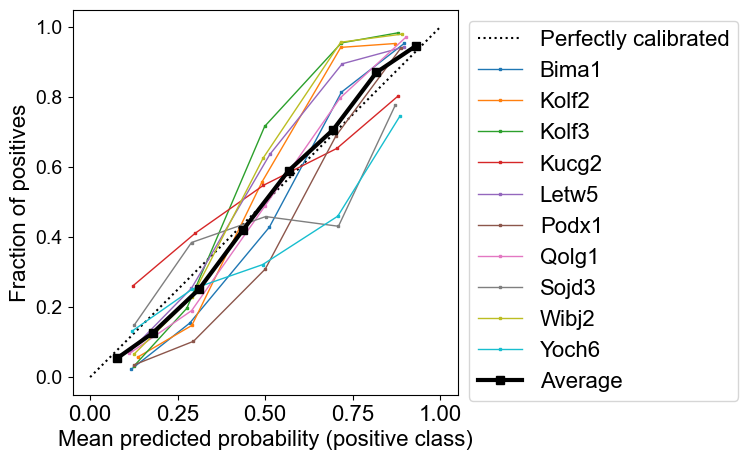

In [16]:
#Script to produce the calibration plot (after having run the script above). Supplementary Fig. 5D
from sklearn.calibration import calibration_curve, CalibrationDisplay

flat_tgts = [
    t
    for tts in tgts
    for t in tts]
flat_probs = [
    t
    for tts in prob_preds
    for t in tts]

fig, ax=plt.subplots(figsize=(5.5,5.0))

for i in range(10):
   # prob_true, prob_pred = calibration_curve(tgts[i], prob_preds[i], n_bins=10)
    disp = CalibrationDisplay.from_predictions(tgts[i], prob_preds[i],ax=ax, label=lines[i], linewidth=1, ms=2)
disp = CalibrationDisplay.from_predictions(flat_tgts, flat_probs,ax=ax, n_bins=8, label="Average", linewidth=3, ms=6, color='black')
ax.set_aspect('equal')
ax.set_xlabel('Mean predicted probability (positive class)')
ax.set_ylabel('Fraction of positives')
ax.legend(bbox_to_anchor=(1.0, 1.0))

plt.show()

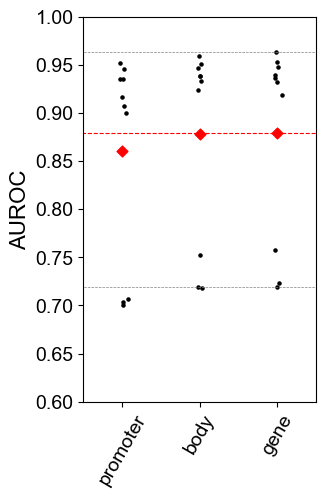

In [14]:
#Script for Supplementary Fig. 4D
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from matplotlib import rcParams
from matplotlib import rc

plt.rcParams.update({'font.size': 16})
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})


AUC_svm=np.zeros(len(lines))
AUC_pm1k=np.zeros(len(lines))
AUC_body=np.zeros(len(lines))

i=0
for test_line in lines:
    filename="AUCs/"+test_line+"_svm_auc.csv"
    data=np.genfromtxt(filename, delimiter=",")
    AUC_svm[i]=auc(np.transpose(data)[0],np.transpose(data)[1])
    
    filename="AUCs/"+test_line+"_svm_pm1k.csv"
    data_pm1k=np.genfromtxt(filename, delimiter=",")
    AUC_pm1k[i]=auc(np.transpose(data_pm1k)[0],np.transpose(data_pm1k)[1])
    
    filename="AUCs/"+test_line+"_svm_auc_body.csv"
    data_body=np.genfromtxt(filename, delimiter=",")
    AUC_body[i]=auc(np.transpose(data_body)[0],np.transpose(data_body)[1])

    i+=1
    
fig, ax=plt.subplots(figsize=(3,5))
plt.rc('xtick', labelsize=16) 

#Plot AUROCs
ax.scatter(np.zeros(10)+np.random.normal(0, 0.02,10), AUC_pm1k, color='black', s=5)
ax.scatter(np.zeros(1), np.mean(AUC_pm1k), color='red', marker="D", s=30)

ax.scatter(np.ones(10)+np.random.normal(0, 0.02,10), AUC_body, color='black', s=5)
ax.scatter(np.ones(1), np.mean(AUC_body), color='red', marker="D", s=30)

ax.scatter(np.ones(10)*2+np.random.normal(0, 0.02,10), AUC_svm, color='black', s=5)
ax.scatter(np.ones(1)*2, np.mean(AUC_svm), color='red', marker="D", s=30)

ax.plot([-2.5,3.5], [np.mean(AUC_svm), np.mean(AUC_svm)], color='red', linestyle='dashed', linewidth=0.8)
ax.plot([-2.5,3.5], [np.min(AUC_svm), np.min(AUC_svm)], color='gray', linestyle='dashed', linewidth=0.5)
ax.plot([-2.5,3.5], [np.max(AUC_svm), np.max(AUC_svm)], color='gray', linestyle='dashed', linewidth=0.5)
ax.set_ylabel("AUROC")
ax.set_xlim([-0.5,2.5])
ax.set_ylim([0.6,1.0])
ax.set_xticks([0,1,2],["promoter", "body", "gene"], rotation=60)
plt.show()
#plt.savefig("Fig_S4D.png", format='png',bbox_inches='tight', dpi=300)

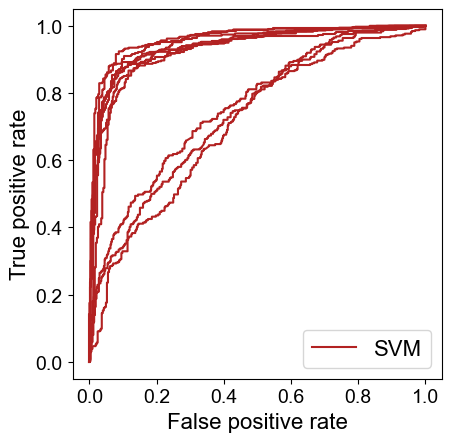

In [22]:
#Script to obtain Supplementary Fig. 5E

#Produce the ROC curves.
AUC_svm=np.zeros(len(lines))

fig, ax=plt.subplots()
ax.set_aspect('equal')
i=0
for test_line in lines:
    filename="AUCs/"+test_line+"_svm_auc.csv"
    data=np.genfromtxt(filename, delimiter=",")
    if test_line=='Bima1':
        ax.plot(np.transpose(data)[0],np.transpose(data)[1], color='firebrick', label='SVM')
    else:
        ax.plot(np.transpose(data)[0],np.transpose(data)[1], color='firebrick')
    AUC_svm[i]=auc(np.transpose(data)[0],np.transpose(data)[1])
    i+=1
ax.legend()
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
plt.show()#savefig("Fig_S5E.png", format='png',bbox_inches='tight', dpi=300)

In [17]:
#Script for predictive accuracy of the SVM pipeline with bootstrapping. 
#Note that the scores files need to be already imported (see script without bootstrapping).

from sklearn.metrics import auc

epig_vars=['K4', 'K9', 'K27', 'ATAC']

n_boots=10 #Note that for the data presented in the manuscript the value used was 1000.
accuracy=np.zeros([10,n_boots])
aucs=np.zeros([10,n_boots])

#Seed initialisation for Bootstrap
np.random.seed(34601)

n_train=9 #9 datapoints in training set
#Cycle over all cell lines to test all of them from the other 9
tline=0
for test_line in lines:
    #Binarise transcription for the training data and assign a binarisation to the test data (ground truth).
    training_lines=lines.copy()
    training_lines.remove(test_line)
    for s in range(n_boots):
        #Bootstrap. Sample with replacement trining set.
        rvect=np.random.choice(9, 9, replace=True)
        boots_lines=[training_lines[i] for i in rvect]
        i=0
        boots_cols=[None] * n_train
        for line in boots_lines:
            if boots_lines[0:i].count(line)>0:
                boots_cols[i]=boots_lines[i]+"_"+str(boots_lines[0:i].count(line))
            else:
                boots_cols[i]=boots_lines[i]
            i+=1
        DE_boots=pd.DataFrame(data=DE_genes['geneid'])
        for l in range(n_train):
            DE_boots[boots_cols[l]]=DE_genes[boots_lines[l]]
        DE_boots[test_line]=DE_genes[test_line]
        
        #Exclude genes with all zeros in the training dataset.
        zero_genes=[]
        for gene in DE_boots['geneid']:
            if DE_boots[boots_cols][DE_boots.geneid==gene].sum(axis=1).values[0]==0:
                zero_genes.append(gene)
        DE_boots=DE_boots[~DE_boots.geneid.isin(zero_genes)]
        DE_boots=DE_boots.reset_index(drop=True)
        #Feed the bootstrapping sample
        DE_bin_train, test_ground_truth=main_funcs.binarize_test(DE_boots,boots_cols, test_line)

        vars = pd.DataFrame(columns=['geneid', 'line', 'K4', 'K9', 'K27', 'ATAC', 'expression'])
        for l in range(n_train):
            for gene in DE_bin_train['geneid']:
                vars.loc[len(vars)] = [gene, line, intensities_K4.loc[intensities_K4['geneid'] == gene, boots_lines[l]].values[0], 
                                       intensities_K9.loc[intensities_K9['geneid'] == gene, boots_lines[l]].values[0], 
                                       intensities_K27.loc[intensities_K27['geneid'] == gene, boots_lines[l]].values[0], 
                                       intensities_ATAC.loc[intensities_ATAC['geneid'] == gene, boots_lines[l]].values[0], 
                                       DE_bin_train.loc[DE_bin_train['geneid'] == gene, boots_cols[l] + '_binary'].values[0]]

        genes_test=pd.DataFrame(columns=['geneid', 'test_line', 'K4', 'K9', 'K27', 'ATAC'])
        for gene in DE_bin_train['geneid']:
            genes_test.loc[len(genes_test)] = [gene, test_line,
                                        intensities_K4.loc[intensities_K4['geneid'] == gene, test_line].values[0], 
                                        intensities_K9.loc[intensities_K9['geneid'] == gene, test_line].values[0], 
                                        intensities_K27.loc[intensities_K27['geneid'] == gene, test_line].values[0], 
                                        intensities_ATAC.loc[intensities_ATAC['geneid'] == gene, test_line].values[0]]
        #SVM for prediction
        probs_prediction, prediction=main_funcs.SVM_prediction(DE_bin_train['geneid'], vars, genes_test, epig_vars)
        #ROC curve 
        tgt=test_ground_truth.transcription.to_numpy(dtype=bool)
        fpr, tpr, thres=sk.metrics.roc_curve(tgt,probs_prediction)

        #General accuracy
        accuracy[tline,s]=sum(test_ground_truth.transcription.to_numpy(dtype=bool)==prediction)/len(DE_bin_train['geneid'])
        aucs[tline,s]=auc(fpr,tpr)
    tline+=1
    print(test_line)
    
np.savetxt('accuracy_svm_boots_10.csv', accuracy, delimiter=",")
np.savetxt('auc_svm_boots_10.csv', aucs, delimiter=",")

Bima1
Kolf2
Kolf3
Kucg2
Letw5
Podx1
Qolg1
Sojd3
Wibj2
Yoch6


In [18]:
#Script to benchmark the SVM pipeline with a logistic regression (same test).

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn import pipeline
from sklearn import preprocessing

n_boots=10 #Note that for the data presented in the manuscript the value used was 1000.
accuracy_log=np.zeros([10,n_boots])
aucs_log=np.zeros([10,n_boots])

_pipeline_log = pipeline.Pipeline([
    ('normalize', preprocessing.MinMaxScaler()), 
    ('logistic_reg', LogisticRegression())
])

#Seed initialisation for Bootstrap
np.random.seed(34601)

n_train=9 #9 datapoints in training set
#Cycle over all cell lines to test all of them from the other 9
tline=0
for test_line in lines:
    #Binarise transcription for the training data and assign a binarisation to the test data (ground truth).
    training_lines=lines.copy()
    training_lines.remove(test_line)
    for s in range(n_boots):
        #Bootstrap. Sample with replacement trining set.
        rvect=np.random.choice(9, 9, replace=True)
        boots_lines=[training_lines[i] for i in rvect]
        i=0
        boots_cols=[None] * n_train
        for line in boots_lines:
            if boots_lines[0:i].count(line)>0:
                boots_cols[i]=boots_lines[i]+"_"+str(boots_lines[0:i].count(line))
            else:
                boots_cols[i]=boots_lines[i]
            i+=1
        DE_boots=pd.DataFrame(data=DE_genes['geneid'])
        for l in range(n_train):
            DE_boots[boots_cols[l]]=DE_genes[boots_lines[l]]
        DE_boots[test_line]=DE_genes[test_line]
        
        #Exclude genes with all zeros in the training dataset.
        zero_genes=[]
        for gene in DE_boots['geneid']:
            if DE_boots[boots_cols][DE_boots.geneid==gene].sum(axis=1).values[0]==0:
                zero_genes.append(gene)
        DE_boots=DE_boots[~DE_boots.geneid.isin(zero_genes)]
        DE_boots=DE_boots.reset_index(drop=True)
        #Feed the bootstrapping sample
        DE_bin_train, test_ground_truth=main_funcs.binarize_test(DE_boots,boots_cols, test_line)

        vars = pd.DataFrame(columns=['geneid', 'line', 'K4', 'K9', 'K27', 'ATAC', 'expression'])
        for l in range(n_train):
            for gene in DE_bin_train['geneid']:
                vars.loc[len(vars)] = [gene, line, intensities_K4.loc[intensities_K4['geneid'] == gene, boots_lines[l]].values[0], 
                                       intensities_K9.loc[intensities_K9['geneid'] == gene, boots_lines[l]].values[0], 
                                       intensities_K27.loc[intensities_K27['geneid'] == gene, boots_lines[l]].values[0], 
                                       intensities_ATAC.loc[intensities_ATAC['geneid'] == gene, boots_lines[l]].values[0], 
                                       DE_bin_train.loc[DE_bin_train['geneid'] == gene, boots_cols[l] + '_binary'].values[0]]

        genes_test=pd.DataFrame(columns=['geneid', 'test_line', 'K4', 'K9', 'K27', 'ATAC'])
        for gene in DE_bin_train['geneid']:
            genes_test.loc[len(genes_test)] = [gene, test_line,
                                        intensities_K4.loc[intensities_K4['geneid'] == gene, test_line].values[0], 
                                        intensities_K9.loc[intensities_K9['geneid'] == gene, test_line].values[0], 
                                        intensities_K27.loc[intensities_K27['geneid'] == gene, test_line].values[0], 
                                        intensities_ATAC.loc[intensities_ATAC['geneid'] == gene, test_line].values[0]]

        #Logistic regression for prediction
        probs_logistic_pred=[]
        logistic_pred=[]
        for gene in DE_bin_train['geneid']:
            gene_instance = vars[vars['geneid'] == gene]
            test_vect=genes_test.loc[genes_test['geneid']==gene,epig_vars]
            y_score = _pipeline_log.fit(gene_instance[epig_vars], gene_instance['expression'].values).predict_proba(test_vect)
            pred = _pipeline_log.fit(gene_instance[epig_vars], gene_instance['expression'].values).predict(test_vect)
            probs_logistic_pred.append(y_score[0][1])
            logistic_pred.append(pred[0])        
        #ROC curve and save to file
        tgt=test_ground_truth.transcription.to_numpy(dtype=bool)
        fpr, tpr, thres=sk.metrics.roc_curve(tgt,probs_logistic_pred)

        #General accuracy
        accuracy_log[tline,s]=sum(test_ground_truth.transcription.to_numpy(dtype=bool)==logistic_pred)/len(DE_bin_train['geneid'])
        aucs_log[tline,s]=auc(fpr,tpr)
    tline+=1
    print(test_line)
    
np.savetxt('accuracy_log_boots_10.csv', accuracy_log, delimiter=",")
np.savetxt('auc_log_boots_10.csv', aucs_log, delimiter=",")

Bima1
Kolf2
Kolf3
Kucg2
Letw5
Podx1
Qolg1
Sojd3
Wibj2
Yoch6


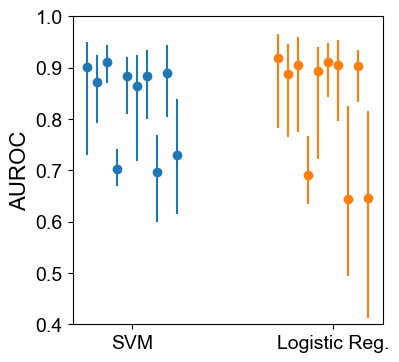

In [20]:
#Script to obtain Supplementary Fig. 5F

aucs=np.genfromtxt("auc_svm_boots_10.csv", delimiter=',')
aucs_log=np.genfromtxt("auc_log_boots_10.csv", delimiter=',')

low=[]
high=[]
means=[]
low_log=[]
high_log=[]
means_log=[]
for i in range(len(lines)):
    means.append(np.mean(aucs[i,:]))
    high.append(np.quantile(aucs[i,:], 0.975))
    low.append(np.quantile(aucs[i,:], 0.025))
    means_log.append(np.mean(aucs_log[i,:]))
    high_log.append(np.quantile(aucs_log[i,:], 0.975))
    low_log.append(np.quantile(aucs_log[i,:], 0.025))

plt.rcParams.update({'font.size': 16})
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

fig, axs = plt.subplots(figsize=(4, 4))

x=np.arange(2)
# plot violin plot
lowerr=np.array(means)-np.array(low)
higherr=np.array(high)-np.array(means)
lowerr_log=np.array(means_log)-np.array(low_log)
higherr_log=np.array(high_log)-np.array(means_log)
axs.errorbar(np.arange(10)*0.05-0.225,means,yerr=[lowerr, higherr], fmt='o')
axs.errorbar(np.arange(10)*0.05+0.725,means_log,yerr=[lowerr_log, higherr_log], fmt='o')
axs.set_ylim([0.4,1])
#axs.axhline(0.0, linestyle='--', color='gray')
axs.set_xticks(x, ["SVM","Logistic Reg."])
axs.set_ylabel("AUROC")
plt.show()
#axs.set_title("Distribution of log-resc.coeffs.")

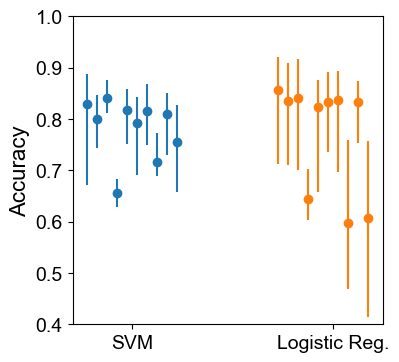

In [21]:
#Script to obtain Supplementary Fig. 5C

acc=np.genfromtxt("accuracy_svm_boots_10.csv", delimiter=',')
acc_log=np.genfromtxt("accuracy_log_boots_10.csv", delimiter=',')

acclow=[]
acchigh=[]
accmeans=[]
acclow_log=[]
acchigh_log=[]
accmeans_log=[]
for i in range(len(lines)):
    accmeans.append(np.mean(acc[i,:]))
    acchigh.append(np.quantile(acc[i,:], 0.975))
    acclow.append(np.quantile(acc[i,:], 0.025))
    accmeans_log.append(np.mean(acc_log[i,:]))
    acchigh_log.append(np.quantile(acc_log[i,:], 0.975))
    acclow_log.append(np.quantile(acc_log[i,:], 0.025))

plt.rcParams.update({'font.size': 16})
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})

fig, axs = plt.subplots(figsize=(4, 4))

x=np.arange(2)
# plot violin plot
lowerr=np.array(accmeans)-np.array(acclow)
higherr=np.array(acchigh)-np.array(accmeans)
lowerr_log=np.array(accmeans_log)-np.array(acclow_log)
higherr_log=np.array(acchigh_log)-np.array(accmeans_log)
axs.errorbar(np.arange(10)*0.05-0.225,accmeans,yerr=[lowerr, higherr], fmt='o')
axs.errorbar(np.arange(10)*0.05+0.725,accmeans_log,yerr=[lowerr_log, higherr_log], fmt='o')
axs.set_ylim([0.4,1])
#axs.axhline(0.0, linestyle='--', color='gray')
axs.set_xticks(x, ["SVM","Logistic Reg."])
axs.set_ylabel("Accuracy")
plt.show()#savefig("Fig_S5D.png", format='png',bbox_inches='tight', dpi=300)